Input: Network Graph
measure connected edges

Construct linear program 

Constraints
Oobjective

Measure X_C for all edges 
Compute witnesses

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from scipy.optimize import linprog
import numpy as np

def generate_random_connected_graph(min_nodes=5, max_nodes=10):
    """
    Generate a connected undirected graph with a random number of nodes and edges.
    
    Parameters:
        min_nodes (int): minimum number of nodes
        max_nodes (int): maximum number of nodes
    
    Returns:
        G (networkx.Graph): a connected undirected graph
    """
    # Random number of nodes
    num_nodes = random.randint(min_nodes, max_nodes)
    
    # Maximum number of edges in a simple undirected graph
    max_edges = num_nodes * (num_nodes - 1) // 2
    
    # Random number of edges (at least n-1 for connectivity)
    num_edges = random.randint(num_nodes - 1, max_edges)
    
    # Start with a random spanning tree (connected)
    G = nx.random_labeled_tree(n=num_nodes)
    
    # Add extra edges randomly if needed
    while G.number_of_edges() < num_edges:
        u = random.randint(0, num_nodes - 1)
        v = random.randint(0, num_nodes - 1)
        if u != v and not G.has_edge(u, v):
            G.add_edge(u, v)
    
    return G

def draw_pretty_graph(graph):
    """
    Draw a networkx graph with a visually appealing layout.
    """
    # Optional: assign random weights for visualization
    for u, v in graph.edges():
        graph[u][v]['weight'] = 1
    
    # Choose layout
    pos = nx.spring_layout(graph, seed=42)  # spring layout is visually nice
    
    # Draw nodes
    nx.draw_networkx_nodes(graph, pos, node_size=800, node_color='lightgreen', edgecolors='black')
    
    # Draw edges with widths proportional to weights
    edges = graph.edges(data=True)
    nx.draw_networkx_edges(
        graph, pos,
        edgelist=edges,
        width=[d['weight'] * 0.5 for (_, _, d) in edges],
        edge_color='gray'
    )
    
    # Draw labels
    nx.draw_networkx_labels(graph, pos, font_size=12, font_color='darkblue', font_weight='bold')
    
    # Add title
    plt.title("Graph Visualization", fontsize=16)
    plt.axis('off')
    plt.show()


In [704]:
from qiskit import QuantumCircuit
import networkx as nx
import matplotlib.pyplot as plt

def ghz_circuit(n):
    # Create GHZ circuit
    qc = QuantumCircuit(n)
    qc.h(0)
    for i in range(1, n):
        qc.cx(0, i)

    return qc

    

def ghz_circuit_graph(circuit):
    """
    Generate a graph from an n-qubit GHZ state circuit.
    Nodes are qubits, edges are CNOT gates (control -> target).
    
    Args:
        n (int): Number of qubits
    
    Returns:
        networkx.DiGraph: Directed graph of qubits and CNOTs
    """
    # Create a directed graph
    G = nx.Graph()
    # Add nodes (qubits)
    for q in range(n):
        G.add_node(q)
    
    for instruction, qargs, _ in circuit.data:
        if instruction.name == "cx":
            control = circuit.find_bit(qargs[0]).index
            target  = circuit.find_bit(qargs[1]).index
            G.add_edge(control, target)
    
    return G.to_undirected()

def plot_graph(G):
    """
    Plot the graph with NetworkX
    """
    pos = nx.circular_layout(G)  # nodes in a circle
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1000, arrowsize=20)
    plt.title("GHZ Circuit Graph")
    plt.show()




# Efficient Numerically-Optimized W_C for GME Detection

## Goal
Construct a **cut witness \( W_C \)** for a fundamental cut \( C \) that:
- Detects genuine multipartite entanglement (GME) efficiently
- Uses **numerically optimized coefficients**
- Scales well with the number of qubits

---

## 1. Parametrize \( W_C \)

For a given fundamental cut \( C \) in graph \( G(V,E) \):

\[
W_C = \sum_{e \in \text{cut edges}} a_e \, I_e + b_e \, \Phi_e
\]

Where:

- \( I_e \) = 2-qubit identity on edge \( e \)
- \( \Phi_e \) = projector onto a maximally entangled state (e.g., \(|\Phi^+\rangle\))
- \( a_e, b_e \) = **coefficients to optimize numerically**
- \(\text{cut edges}\) = edges connecting the two sides of the cut

> The identity ensures the **separable bound is non-negative**, while the projector detects entanglement along the edge.

In [705]:
import networkx as nx
import numpy as np
from qiskit.quantum_info import Operator

# Define Phi+ projector and identity for 2 qubits
phi_plus = np.array([[0.5,0,0,0.5],
                     [0,0,0,0],
                     [0,0,0,0],
                     [0.5,0,0,0.5]])
Phi_e_op = Operator(phi_plus)
I_e_op = Operator(np.eye(4))

def edges_crossing_cut(G, C, edge_index_map):
    C = set(C)
    crossing_edges = []
    for u, v in G.edges():
        if (u in C and v not in C) or (v in C and u not in C):
            crossing_edges.append(edge_index_map[tuple(sorted((u, v)))])
    return crossing_edges


# Generate symbolic witness for a cut
def generate_witness(G, cut_nodes):
    """
    For a given cut, generate the 2-qubit operators for each edge crossing the cut.
    Returns:
        edge_ops: list of tuples (edge, I_op, Phi_op)
    """
    edge_ops = []
    for edge in edges_crossing_cut(G, cut_nodes):
        I_op = Operator(np.eye(4))  # 2-qubit identity
        Phi_op = Operator(np.array([[1,0,0,1],
                                    [0,0,0,0],
                                    [0,0,0,0],
                                    [1,0,0,1]])/2)  # |Φ+><Φ+|
        edge_ops.append((edge, I_op, Phi_op))
    return edge_ops

# Function to generate fundamental cuts (MST-based)
def fundamental_cuts(G):
# 1. Minimum spanning tree
    T = nx.minimum_spanning_tree(G, weight='weight')

    cuts = []

    # 2. Fundamental cuts: one per MST edge
    for u, v in T.edges():
        # Temporarily remove edge
        T.remove_edge(u, v)

        # Connected components after removal
        components = list(nx.connected_components(T))
        assert len(components) == 2  # MST edge removal splits into exactly two parts

        C1, C2 = components

        # Choose smaller side (guaranteed non-empty)
        cut = C1 if len(C1) <= len(C2) else C2
        cuts.append(set(cut))

        # Restore edge
        T.add_edge(u, v)

    return cuts


from qiskit.quantum_info import Operator
from functools import reduce

def lift_operator(op, n_qubits, edge):
    """
    Lift a 2-qubit operator to an n-qubit operator on qubits specified by 'edge'.
    
    Args:
        op: Qiskit Operator (2-qubit, shape 4x4)
        n_qubits: total number of qubits
        edge: tuple (q0, q1) indicating which qubits op acts on
    
    Returns:
        Operator: full n-qubit operator
    """
    q0, q1 = edge
    if q0 > q1:
        q0, q1 = q1, q0  # ensure order
    
    # Start with identity
    full_op = 1
    for i in range(n_qubits):
        if i == q0:
            # Place first qubit of op
            full_op = np.kron(full_op, np.array([[1,0],[0,1]])) if full_op is 1 else full_op
        elif i == q1:
            # Combine with second qubit of op
            # Identify previous kron
            continue
        else:
            full_op = np.kron(full_op, np.eye(2))

    # Use Qiskit's expand operator
    from qiskit.quantum_info import Operator
    return Operator(Operator(op).expand(Operator(np.eye(2**(n_qubits-2)))))


<>:91: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
<>:91: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
/tmp/ipykernel_71896/1350661052.py:91: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
  full_op = np.kron(full_op, np.array([[1,0],[0,1]])) if full_op is 1 else full_op


---

## 2. Optimize coefficients numerically

1. **Sample biseparable states** \(\{\sigma_i\}\) across the cut.  
2. **Set up a linear program (LP):**

\[
\text{maximize } -\langle W_C, \rho \rangle
\]

Subject to:

\[
\langle W_C, \sigma_i \rangle \ge 0 \quad \forall \, i
\]

- \(\rho\) = the target state for GME detection  
- Variables = \(a_e, b_e\) for each edge crossing the cut  

3. **Solve LP** → yields **numerically optimized coefficients** \(a_e^*, b_e^*\).

---

In [ ]:
# LP solver for all fundamental cuts
import numpy as np
from scipy.optimize import linprog

def optimize_all_cuts(G, cuts, target_rho):
    import numpy as np
    from scipy.optimize import linprog

    # 1. Precompute edge list and index map
    edge_list = list(G.edges())
    n_edges = len(edge_list)
    edge_index_map = {tuple(sorted(edge)): i for i, edge in enumerate(edge_list)}

    target_rho = np.array(target_rho, dtype=float)
    assert len(target_rho) == len(edge_list)

    # 2. Convert cuts (node sets) to edge indices
    cuts_indices = [edges_crossing_cut(G, C, edge_index_map) for C in cuts]

    # 3. Ensure all edges appear in at least one cut
    edges_in_cuts = set(e for cut in cuts_indices for e in cut)
    all_edge_indices = set(range(len(edge_list)))
    for e in all_edge_indices - edges_in_cuts:
        cuts_indices.append([e])


    c = np.array(-1 * target_rho, dtype=float)

    n_cuts = len(cuts_indices)
    A_ub = np.zeros((n_cuts, n_edges))

    b_ub = np.ones(n_cuts)
    for i, edge_idx_list in enumerate(cuts_indices):
        A_ub[i, edge_idx_list] = 1

    # 6. Bounds: weights between 0 and 1
    bounds = [(0, 1) for _ in range(n_edges)]

    # 7. Solve LP
    lp_result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')


    # Compute c
    print(np.dot(lp_result.x, target_rho))
    print(-1 * lp_result.fun)
    print(target_rho)

    if lp_result.success:
        c_max = -lp_result.fun  # linear program maximizes sum of weights
        return c_max - np.dot(lp_result.x, target_rho)
    else:
        raise RuntimeError("LP failed: " + lp_result.message)
    


## 3. Construct global SSW

Once each cut witness \( W_C \) is optimized:

\[
W_\text{SSW} = \sum_{C \in \text{fundamental cuts}} w_C \, W_C
\]

- \( w_C \) = optional weighting per cut (can also be optimized)  
- Expectation value on \(\rho\):

\[
\langle W_\text{SSW} \rangle_\rho < 0 \implies \text{GME certified}
\]

---


## 4. Efficiency Advantages

| Feature | Benefit |
|---------|---------|
| Only edges crossing fundamental cuts | Linear in number of edges (no exponential bipartition enumeration) |
| LP optimization | Efficient, scalable; avoids semidefinite programs |
| 2-qubit operators | Fast to compute expectations; memory-friendly |
| Parallelizable per cut | Multiple LPs can run simultaneously |

---

## 5. Summary Workflow

1. Compute **fundamental cuts** of the network graph  
2. For each cut:
   - Identify **edges crossing the cut**  
   - Initialize \( W_C \) with symbolic coefficients \( a_e, b_e \)  
   - Set up **LP constraints** with biseparable states  
   - Solve LP → obtain optimized \( a_e^*, b_e^* \)  
3. Combine optimized cut witnesses → **global SSW**  
4. Evaluate \( \langle W_\text{SSW} \rangle_\rho \) to certify GME  

> This produces an **efficient, numerically optimized SSW** that can detect GME along the fundamental cuts with minimal computational overhead.

In [707]:
from qiskit.quantum_info import Statevector, Pauli

def evaluate_SSW(circuit):
    """
    circuit: Qiskit QuantumCircuit
    network_graph: NetworkX graph representing qubits and edges
    returns: <W_SSW> expectation value
    """

    # Build network graph (fully connected for demo)
    network_graph = nx.complete_graph(circuit.num_qubits)
    draw_pretty_graph(network_graph)

    # 1. Com

    sv = Statevector(circuit)

    n_qubits = circuit.num_qubits
    target_rho = []

     # Build X_i X_j correlations
    target_rho = []
    for i, j in network_graph.edges():
        pauli_X = ['I'] * n_qubits
        pauli_X[i] = 'X'
        pauli_X[j] = 'X'
        val_X = np.real(sv.expectation_value(Pauli(''.join(pauli_X))))

        pauli_Y = ['I'] * n_qubits
        pauli_Y[i] = 'Y'
        pauli_Y[j] = 'Y'
        val_Y = np.real(sv.expectation_value(Pauli(''.join(pauli_Y))))

        pauli_Z = ['I'] * n_qubits
        pauli_Z[i] = 'Z'
        pauli_Z[j] = 'Z'
        val_Z = np.real(sv.expectation_value(Pauli(''.join(pauli_Z))))

        # Edge projector <Phi_ij> = 1/4 (I + X_i X_j - Y_i Y_j + Z_i Z_j)
        phi_ij = 0.25 * (1 + val_X - val_Y + val_Z)
        target_rho.append(phi_ij)

    cuts = fundamental_cuts(network_graph)

    result = optimize_all_cuts(network_graph, cuts, target_rho)
    
    return result



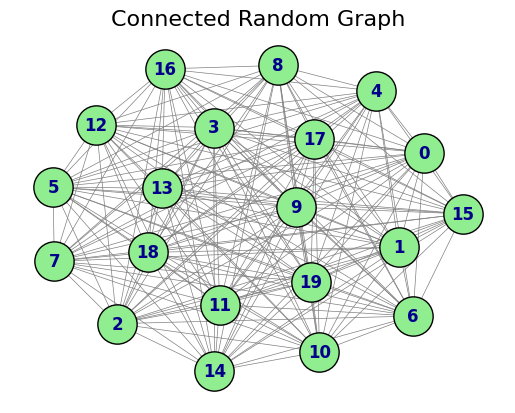

9.499999999999998
9.499999999999998
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
Optimized SSW expectation value <W_SSW> for 20-qubit circuit: 0.0


In [708]:
import networkx as nx
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import numpy as np

# --------------------------
# Assume these are already implemented and imported:
# - fundamental_cuts
# - generate_witness
# - lift_operatorYou use G instead of network_graph for cuts
# - optimize_all_cuts
# - evaluate_global_SSW
# - evaluate_SSW
# --------------------------

# --------------------------
# 1. Create a GHZ circuit
# --------------------------
def create_ghz_circuit(n_qubits):
    qc = QuantumCircuit(n_qubits)
    for i in range(0, n_qubits):
        qc.h(i)
    for i in range(1, n_qubits):
        qc.cx(0, i)
    qc.cx(1, 2)
    return qc

from qiskit import QuantumCircuit
import numpy as np

def w_state_circuit(n):
    qc = QuantumCircuit(n)
    theta = 2 * np.arccos(np.sqrt((n-1)/n))
    qc.ry(theta, 0)
    
    for i in range(1, n):
        # Controlled rotation on next qubit
        qc.cx(i-1, i)
        # Adjust angle recursively
        theta = 2 * np.arccos(np.sqrt((n-i-1)/(n-i)))
        qc.ry(theta, i)
    
    return qc

def sparse_ghz_circuit(num_qubits, topology="linear_chain"):
    """
    Create a sparse-qubit GHZ-like circuit.
    Uses linear_chain or star connectivity.
    
    Args:
        num_qubits: int, number of qubits
        topology: str, "linear_chain" or "star"
    Returns:
        QuantumCircuit
    """
    qc = QuantumCircuit(num_qubits)
    
    # Start with |0...0>
    # Apply Hadamard on first qubit
    for i in range(0, num_qubits):
        qc.h(i)
    
    if topology == "linear_chain":
        # Apply CNOTs along the chain
        for i in range(num_qubits-1):
            qc.cx(i, i+1)
    elif topology == "star":
        # First qubit is central
        for i in range(1, num_qubits):
            qc.cx(0, i)
    else:
        raise ValueError("Unknown topology")
    
    return qc


# --------------------------
# 2. Example program
# --------------------------zeros
if __name__ == "__main__":
    n_qubits = 20
    
     # Create GHZ circuit
    ghz_circuit = create_ghz_circuit(n_qubits)
    w_circuit = w_state_circuit(n_qubits)
    sghzc = sparse_ghz_circuit(n_qubits)
    # Evaluate SSW expectation
    #W_SSW_value = evaluate_SSW(ghz_circuit)
    #W_SSW_value = evaluate_SSW(w_circuit)
    W_SSW_value = evaluate_SSW(sghzc)
    print(f"Optimized SSW expectation value <W_SSW> for {n_qubits}-qubit circuit:", W_SSW_value)


In [709]:
# --------------------------
# 1. Test fundamental_cuts
# --------------------------
def test_fundamental_cuts():
    G = nx.Graph()
    G.add_edges_from([(0,1),(1,2),(2,3),(0,3)])
    T, cuts = fundamental_cuts(G)
    assert len(cuts) == 3, "MST has 3 edges → 3 fundamental cuts"
    for cut in cuts:
        assert isinstance(cut, set), "Each cut should be a set of nodes"
    print("fundamental_cuts passed")
random_pauli_list
# --------------------------
# 2. Test edges_crossing_cut
# --------------------------
def test_edges_crossing_cut():
    G = nx.Graph()
    G.add_edges_from([(0,1),(1,2),(2,3),(0,3)])
    cut_nodes = {0,1}
    crossing = edges_crossing_cut(G, cut_nodes)
    expected = [(1,2),(0,3)]
    assert set(crossing) == set(expected), f"Expected {expected}, got {crossing}"
    print("edges_crossing_cut passed")

# --------------------------
# 3. Test generate_witness
# --------------------------
def test_generate_witness():
    G = nx.Graph()
    G.add_edges_from([(0,1),(1,2),(2,3),(0,3)])
    cut_nodes = {0,1}
    edge_ops = generate_witness(G, cut_nodes)
    expected_edges = list(edges_crossing_cut(G, cut_nodes))
    assert len(edge_ops) == len(expected_edges), f"Expected {len(expected_edges)} edges crossing cut, got {len(edge_ops)}"
    print("generate_witness passed")

# --------------------------
# 4. Test LP optimization placeholder
# (using trivial biseparable states)
# --------------------------
def test_optimize_all_cuts():
    G = nx.Graph()
    G.add_edges_from([(0,1),(1,2)])
    T, cuts = fundamental_cuts(G)
    
    target_rho = np.array([[0.5,0,0,0.5],
                           [0,0,0,0],
                           [0,0,0,0],
                           [0.5,0,0,0.5]])
    
    optimized = optimize_all_cuts(G, cuts, target_rho)
    for idx, coeffs in optimized.items():
        assert coeffs is not None, "LP should return coefficients"
        print(cuts[idx].nodes())
        print(2*len(edges_crossing_cut(G, cuts[idx].nodes())))
        print(len(coeffs))
        assert len(coeffs) == 2*len(edges_crossing_cut(G, cuts[idx].nodes())), "Coefficient array length mismatch"
    print("optimize_all_cuts passed")

# --------------------------
# 5. Test evaluate_global_SSW
# --------------------------
def test_evaluate_global_SSW():
    G = nx.complete_graph(2)
    cuts = fundamental_cuts(G)[1]
    
    # create full 2-qubit maximally mixed state
    target_rho = np.eye(4)/4
    n_qubits = 2
    
    # create dummy biseparable samples
    biseparable_samples = []
    for _ in range(len(cuts)):
        sigma1 = np.array([[1,0],[0,0]])
        sigma2 = np.array([[0,0],[0,1]])
        biseparable_samples.append([sigma1, sigma2])
    
    optimized = optimize_all_cuts(G, biseparable_samples, target_rho)
    for idx, coeffs in optimized.items():
        assert coeffs is not None, "LP should return coefficients"
    
    print("optimize_all_cuts passed")

# --------------------------
# Run all tests
# --------------------------
if __name__ == "__main__":
    test_fundamental_cuts()
    test_edges_crossing_cut()
    test_generate_witness()
    test_optimize_all_cuts()
    test_evaluate_global_SSW()
    print("All tests passed!")

NameError: name 'random_pauli_list' is not defined